In [1]:
# Enable outputting results interactively. 
# All the results from code in a given cell will be displayed instead of only the last one.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:

import plotly.plotly as py
import plotly.graph_objs as go
import plotly

import cufflinks
cufflinks.go_offline(connected=True)

In [3]:
import folium

from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

import geopandas as gpd
import json

from shapely.geometry import shape, Point

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [5]:
import pandas as pd
import pickle
import numpy as np
import scipy.stats as stats
import sqlite3
import math
import datetime
import matplotlib.dates as mdates

from re import sub
from decimal import Decimal

import re

In [13]:
listings_0 =  pickle.load( open( "../all_SF_listings.p", "rb" ) )

reviews =  pickle.load( open( "../all_SF_reviews.p", "rb" ) )


In [14]:
len(set(listings_0['id']))

29894

In [15]:
# Flag listings of which the min. nights is less than 30 days. Rentals of 30 days and above are not subject to the new regulations.

# boolean values;

listings_0['short_term'] = (listings_0['minimum_nights']<30) * 1 
listings_0['long_term'] = (listings_0['minimum_nights']>=30) * 1

listings_0['scraped_year'] = pd.to_datetime(listings_0['file_scraped_dt']).dt.year 
listings_0['scraped_year'].value_counts()


# ro = listings_0.shape[0]
# listings = listings_0[listings_0['minimum_nights']<30]
# r1 = listings.shape[0]

# r1/ro

chk = listings_0.groupby(['id','short_term', 'long_term']).size().reset_index(name = 'num_scrapes')
chk1 = chk.groupby('id').size().reset_index(name= 'counts')
chk2 = chk1[chk1['counts'] > 1]

chk_id = set(chk2['id'])
len(chk_id)

2017    117566
2016     85420
2018     69594
2019     43805
2015     25980
Name: scraped_year, dtype: int64

2625

In [16]:
listings_0['file_scraped_dt'].describe()

count         342365
unique            46
top       2016-12-03
freq            9066
Name: file_scraped_dt, dtype: object

In [10]:
chk_listings = listings_0[listings_0['id'].isin(chk_id)]
chk_listings = chk_listings.sort_values(by=['id', 'file_scraped_dt'])
chk_listings = chk_listings[['id', 'file_scraped_dt', 'minimum_nights', 'short_term','long_term']]

chk_listings['flag_shifted'] = chk_listings.groupby(['id'])['short_term'].transform(lambda x:x.shift(1))
chk_listings['last_scraped_dt'] = chk_listings.groupby(['id'])['file_scraped_dt'].transform(lambda x:x.shift(1))
chk_listings['minimum_nights_last_scrape'] = chk_listings.groupby(['id'])['minimum_nights'].transform(lambda x:x.shift(1))
chk_listings['change_flag'] = np.where(chk_listings['flag_shifted'].notna(), chk_listings['flag_shifted'] != chk_listings['short_term'], np.nan)
chk_listings2 = chk_listings[chk_listings['change_flag'] == 1]

chk_listings.head()


id file_scraped_dt  minimum_nights  short_term  long_term  \
341301  5193      2015-05-04               1           1          0   
336015  5193      2015-09-02               1           1          0   
329670  5193      2015-11-01               1           1          0   
322744  5193      2015-12-02               1           1          0   
315219  5193      2016-02-02               1           1          0   

        flag_shifted last_scraped_dt  minimum_nights_last_scrape  change_flag  
341301           NaN             NaT                         NaN          NaN  
336015           1.0      2015-05-04                         1.0          0.0  
329670           1.0      2015-09-02                         1.0          0.0  
322744           1.0      2015-11-01                         1.0          0.0  
315219           1.0      2015-12-02                         1.0          0.0

In [11]:
chk3 = chk_listings2.groupby('id').size().reset_index(name='counts')
chk3[chk3['counts'] > 1].sort_values(by='counts', ascending= False)


id  counts
1162   7931074      11
1981  16134193      10
762    4228444       9
1463  10729994       8
1243   8760949       8
414    1725833       8
195     682134       8
348    1336450       7
944    5821220       7
657    3434710       7
421    1783301       7
186     640605       7
713    3812931       7
71      138221       7
1777  14234871       7
295    1094207       6
126     350479       6
1001   6316753       6
99      218567       6
1053   6732541       6
701    3716504       6
477    2062696       6
569    2550991       5
401    1636810       5
270     980783       5
840    4855194       5
136     423300       5
797    4576076       5
235     862201       5
789    4485844       5
...        ...     ...
906    5395767       2
905    5394104       2
112     274334       2
897    5327231       2
884    5217164       2
1005   6338562       2
1010   6364873       2
1020   6452357       2
1071   6898966       2
1100   7182660       2
1098   7181655       2
1097   7163507       2
1089   7038579       2
1087   7030125       2
1084   7010081       2
1083   7010032       2
1081   6993593       2
1076   6959726       2
1060   6785012       2
1029   6523507       2
1059   6784288       2
1057   6765256       2
1054   6742488       2
74      142177       2
1048   6713990       2
75      145886       2
77      148627       2
1038   6604799       2
1037   6604564       2
2613  32062146       2

[649 rows x 2 columns]

In [12]:
chk4 = chk_listings2['file_scraped_dt'].value_counts().reset_index(name='counts').sort_values(by='index')
chk4.head(10)

index  counts
2  2015-09-02     146
6  2015-11-01     120
17 2015-12-02      80
1  2016-02-02     173
11 2016-04-03      93
30 2016-05-02      63
5  2016-06-02     123
38 2016-07-02      57
28 2016-08-02      67
19 2016-09-02      78

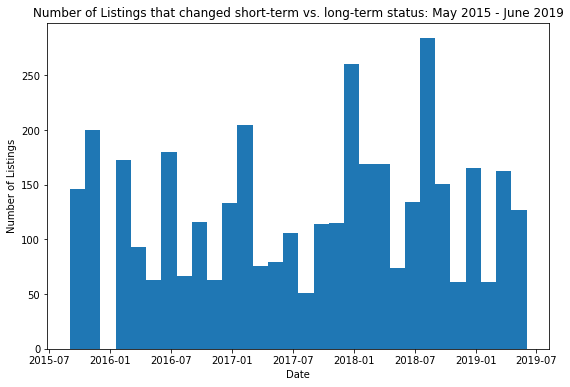

In [13]:
x = pd.to_datetime(chk_listings2['file_scraped_dt']).values
type(x)
x

plt.figure(figsize=(9,6))

plt.hist(x,bins=30)
plt.xlabel('Date')
plt.ylabel('Number of Listings')
plt.title('Number of Listings that changed short-term vs. long-term status: May 2015 - June 2019');



In [14]:
listings_t = listings_0.set_index(pd.DatetimeIndex(listings_0['file_scraped_dt']))
listings_t.shape

listings_short = listings_t[listings_t['short_term'] == 1]
listings_short.shape

listings_long = listings_t[listings_t['long_term'] == 1]
listings_long.shape


conn = sqlite3.connect("airbnb.db")
ls = listings_short.drop('file_scraped_dt', axis = 1)
ls.to_sql('listings_shortterm_db', conn, if_exists='replace')


(342365, 110)

(292558, 110)

(49807, 110)

In [15]:
m_ls = listings_short.resample('D').size().reset_index(name='Counts') 

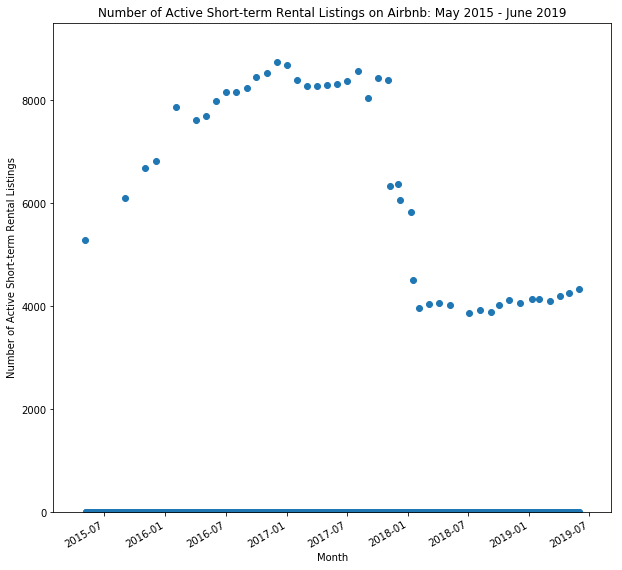

In [16]:
xlinspace = pd.date_range('2015-05-04', periods= m_ls.shape[0], freq='D')

fig, ax = plt.subplots(1,figsize = (10,10))
fig.autofmt_xdate()
plt.scatter(xlinspace,m_ls['Counts'])
ax.set_ylim(0,9500)
plt.xlabel("Month")
plt.ylabel("Number of Active Short-term Rental Listings")
plt.title("Number of Active Short-term Rental Listings on Airbnb: May 2015 - June 2019")

xfmt = mdates.DateFormatter('%m-%d-%y')
# ax.xaxis.set_major_formatter(xfmt)

plt.show();

In [17]:
# standardize property type

f = lambda x: 'BED & BREAKFAST' if x == 'BED AND BREAKFAST' else x

listings_t['property_type_c'] = listings_t['property_type'].str.upper().map(f)

In [18]:
# select a subset of fields in the Listings data. Use the standardized property_type.

sub = listings_t[['file_scraped_dt','scraped_year','id','host_since','host_id','property_type_c', 'room_type', 'minimum_nights', 'neighbourhood', 'review_scores_rating', 'review_scores_accuracy','review_scores_communication','review_scores_cleanliness','review_scores_location','review_scores_checkin','review_scores_value']]
sub.shape

(342365, 16)

In [19]:
del sub['file_scraped_dt']
sub.shape


(342365, 15)

In [20]:
# Initialize a sqlit3 database. Convert the 'sub' dataframe to a sql data table.


sub.to_sql('listings_all_db', conn, if_exists='replace')

In [21]:
# Convert the 'reviews' dataframe to a sql data table.

reviews.to_sql('reviews', conn, if_exists='replace')

In [22]:
# For any given listing, what's the first review date, last review date and number of reviews?


ls_reviews = pd.read_sql_query(
    'select listing_id, \
        min(date) as first_review_dt, \
        max(date) as last_review_dt, \
        count(*) as count_reviews \
        from reviews  \
        group by listing_id  \
        order by count_reviews desc;' ,conn)

# span of time between the first and last review dates in terms of months.

ls_reviews['reviews_history_month'] = (pd.to_datetime(ls_reviews['last_review_dt']) - pd.to_datetime(ls_reviews['first_review_dt']))/np.timedelta64(1, 'M')

ls_reviews.head()


listing_id first_review_dt last_review_dt  count_reviews  \
0      545685      2012-06-28     2019-05-30            741   
1        8739      2009-08-01     2019-05-21            715   
2      205842      2012-07-22     2019-01-01            674   
3     1920033      2013-11-22     2019-05-29            672   
4      585326      2012-07-14     2019-05-28            667   

   reviews_history_month  
0              83.024292  
1             117.620485  
2              77.340397  
3              66.169737  
4              82.432904

In [23]:
ls_reviews['reviews_history_month'].iplot(
    kind='hist',
    histnorm='percent',
  
    xTitle='Months',
    yTitle='(%) of Listings',
    title='Booking History of a Listing <br> Months Difference between the First Review Date and the Last Review Date')

In [24]:
ls_reviews['count_reviews'].iplot(
    kind='hist',
    histnorm='percent',
  
    xTitle='Number of Reviews',
    yTitle='(%) of Listings',
    title='Number of Reviews for a Listing')

In [25]:
plus5_reviews = ls_reviews[ls_reviews['count_reviews']>= 5]

plus5_reviews['count_reviews'].iplot(
    kind='hist',
    histnorm='percent',
  
    xTitle='Number of Reviews',
    yTitle='(%) of Listings',
    title='Number of Reviews for a Listing <br> Listings with a minimum of 5 reviews')

In [26]:
ls_reviews.to_sql('ls_reviews', conn, if_exists='replace')

In [27]:
tab1 = pd.read_sql_query(
    'select id as listing_id, property_type_c, room_type, host_since, \
        min(minimum_nights) as min_min_nights, \
        max(minimum_nights) as max_min_nights, \
        min(file_scraped_dt) as first_scraped_dt, \
        max(file_scraped_dt) as last_scraped_dt ,\
        count(1) as num_obs \
        from listings_all_db \
        group by listing_id;' ,conn)
tab1.head()

tab1.shape

chk_cnt = tab1['listing_id'].value_counts().reset_index(name = 'counts')
chk_cnt[chk_cnt['counts']> 1]

listing_id property_type_c        room_type  host_since  min_min_nights  \
0         958       APARTMENT  Entire home/apt  2008-07-31               1   
1        2822           HOUSE     Private room  2008-09-24               1   
2        3850           HOUSE     Private room  2008-12-08               1   
3        5021       APARTMENT  Entire home/apt  2009-01-29               1   
4        5193       APARTMENT  Entire home/apt  2009-02-05               1   

   max_min_nights     first_scraped_dt      last_scraped_dt  num_obs  
0               2  2015-05-04 00:00:00  2019-06-02 00:00:00       46  
1               1  2015-09-02 00:00:00  2016-06-02 00:00:00        7  
2               1  2015-05-04 00:00:00  2015-05-04 00:00:00        1  
3               1  2016-12-03 00:00:00  2018-01-17 00:00:00       12  
4              30  2015-05-04 00:00:00  2017-03-02 00:00:00       16

(29894, 9)

Empty DataFrame
Columns: [index, counts]
Index: []

In [28]:
tab1[tab1['num_obs'] <= 1].head()

listing_id property_type_c        room_type  host_since  min_min_nights  \
2         3850           HOUSE     Private room  2008-12-08               1   
8         6906       APARTMENT      Shared room  2009-05-08               1   
26       10840       APARTMENT  Entire home/apt  2009-09-15               3   
29       11319            None  Entire home/apt  2009-09-21               3   
43       16428       APARTMENT  Entire home/apt  2009-12-17               5   

    max_min_nights     first_scraped_dt      last_scraped_dt  num_obs  
2                1  2015-05-04 00:00:00  2015-05-04 00:00:00        1  
8                1  2016-10-01 00:00:00  2016-10-01 00:00:00        1  
26               3  2015-09-02 00:00:00  2015-09-02 00:00:00        1  
29               3  2015-05-04 00:00:00  2015-05-04 00:00:00        1  
43               5  2016-08-02 00:00:00  2016-08-02 00:00:00        1

In [29]:
# Checking if there is more than one property type associated with a given listing.

chk1 = tab1.groupby('listing_id')['property_type_c'].size().reset_index()
chk1[chk1['property_type_c'] > 1]



Empty DataFrame
Columns: [listing_id, property_type_c]
Index: []

In [30]:
# Checking if there is more than one room type associated with a given listing.

chk2 = tab1.groupby('listing_id')['room_type'].size().reset_index()
chk2[chk2['room_type'] > 1]



Empty DataFrame
Columns: [listing_id, room_type]
Index: []

In [31]:
tab1.to_sql('ls_dt_range', conn, if_exists='replace')


In [32]:
test = pd.read_sql_query(
    'select *, \
        (max_min_nights - min_min_nights) as diff_min_nights \
        from ls_dt_range \
        order by diff_min_nights desc;',conn)
test.head()




index  listing_id property_type_c        room_type  host_since  \
0  19256    15344978       APARTMENT     Private room  2008-06-25   
1  10364     8066789       APARTMENT     Private room  2011-10-14   
2  23282    19813606     CONDOMINIUM  Entire home/apt  2014-07-10   
3  24520    21483044      APARTHOTEL     Private room  2016-02-09   
4  10594     8184928       APARTMENT  Entire home/apt  2012-11-23   

   min_min_nights  max_min_nights     first_scraped_dt      last_scraped_dt  \
0               2       100000000  2017-02-02 00:00:00  2019-06-02 00:00:00   
1               2            1125  2015-09-02 00:00:00  2019-06-02 00:00:00   
2               1            1000  2017-08-02 00:00:00  2019-06-02 00:00:00   
3               1            1000  2017-11-01 00:00:00  2018-08-06 00:00:00   
4               1             999  2015-11-01 00:00:00  2019-06-02 00:00:00   

   num_obs  diff_min_nights  
0       23         99999998  
1       44             1123  
2       25              999  
3       12              999  
4       43              998

In [33]:
ls_tab = pd.read_sql_query(
    'select a.*, \
        b.first_review_dt, \
        b.last_review_dt,\
        b.count_reviews, \
        b.reviews_history_month \
        from ls_dt_range \
        as a \
        left join ls_reviews as b \
        on a.listing_id = b.listing_id',conn)

ls_tab.head()

index  listing_id property_type_c        room_type  host_since  \
0      0         958       APARTMENT  Entire home/apt  2008-07-31   
1      1        2822           HOUSE     Private room  2008-09-24   
2      2        3850           HOUSE     Private room  2008-12-08   
3      3        5021       APARTMENT  Entire home/apt  2009-01-29   
4      4        5193       APARTMENT  Entire home/apt  2009-02-05   

   min_min_nights  max_min_nights     first_scraped_dt      last_scraped_dt  \
0               1               2  2015-05-04 00:00:00  2019-06-02 00:00:00   
1               1               1  2015-09-02 00:00:00  2016-06-02 00:00:00   
2               1               1  2015-05-04 00:00:00  2015-05-04 00:00:00   
3               1               1  2016-12-03 00:00:00  2018-01-17 00:00:00   
4               1              30  2015-05-04 00:00:00  2017-03-02 00:00:00   

   num_obs first_review_dt last_review_dt  count_reviews  \
0       46      2009-07-23     2019-05-16          199.0   
1        7      2010-07-25     2016-05-08           55.0   
2        1      2009-07-16     2015-01-01          120.0   
3       12      2011-07-04     2017-12-31            6.0   
4       16      2009-09-29     2016-12-20          309.0   

   reviews_history_month  
0             117.751905  
1              69.455225  
2              65.545494  
3              77.931785  
4              86.704039

In [34]:
ls_tab['first_review_dt'].isnull().sum()

8683

In [35]:
chk =ls_tab[['listing_id','host_since', 'first_scraped_dt', 'last_scraped_dt','count_reviews', 'first_review_dt', 'last_review_dt']]

# it's problematic when the last review date is as long as several years after the last scraped date.

chk['chk_dt1'] = (pd.to_datetime(chk['last_review_dt']) - pd.to_datetime(chk['last_scraped_dt'])).dt.days
chk2 = chk[chk['chk_dt1'] > 0]
chk2.sort_values(by='chk_dt1',ascending = False).head(10)
chk3 = chk2[chk2['chk_dt1'] > 1000]
chk3.shape


# Presumably the listing is active long after the last booking.
chk.sort_values(by='chk_dt1').head(10)

Empty DataFrame
Columns: [listing_id, host_since, first_scraped_dt, last_scraped_dt, count_reviews, first_review_dt, last_review_dt, chk_dt1]
Index: []

(0, 8)

listing_id  host_since     first_scraped_dt      last_scraped_dt  \
134       44680  2010-08-09  2015-05-04 00:00:00  2019-06-02 00:00:00   
181       59831  2010-11-15  2018-08-06 00:00:00  2019-06-02 00:00:00   
221       71779  2011-01-30  2018-08-06 00:00:00  2019-06-02 00:00:00   
337      138681  2011-04-16  2017-01-01 00:00:00  2019-03-06 00:00:00   
563      261358  2011-10-06  2019-02-01 00:00:00  2019-06-02 00:00:00   
617      284811  2011-11-20  2019-01-09 00:00:00  2019-05-03 00:00:00   
119       41743  2010-07-27  2016-04-03 00:00:00  2017-11-01 00:00:00   
934      505763  2012-02-09  2018-08-06 00:00:00  2019-06-02 00:00:00   
944      511991  2011-06-20  2018-08-06 00:00:00  2019-06-02 00:00:00   
44        16551  2009-07-08  2015-05-04 00:00:00  2018-11-03 00:00:00   

     count_reviews first_review_dt last_review_dt  chk_dt1  
134            3.0      2010-08-20     2010-10-04  -3163.0  
181            1.0      2011-05-23     2011-05-23  -2932.0  
221            2.0      2011-08-02     2011-09-30  -2802.0  
337            2.0      2011-08-13     2011-08-23  -2752.0  
563            1.0      2011-11-23     2011-11-23  -2748.0  
617            1.0      2012-02-04     2012-02-04  -2645.0  
119            7.0      2010-08-01     2010-10-22  -2567.0  
934            8.0      2012-06-07     2012-07-03  -2525.0  
944            1.0      2012-09-14     2012-09-14  -2452.0  
44             7.0      2011-04-09     2012-04-23  -2385.0

In [36]:
# listings_to_chk.to_sql('listings_to_chk', conn, if_exists='replace')

# chk4 = pd.read_sql_query(
#     'select id as listing_id, property_type, room_type, host_since, \
#         min(minimum_nights) as min_min_nights, \
#         max(minimum_nights) as max_min_nights, \
#         min(file_scraped_dt) as first_scraped_dt, \
#         max(file_scraped_dt) as last_scraped_dt ,\
#         count(1) as num_obs \
#         from listings_to_chk \
#         group by listing_id;' ,conn)

# chk4.head()

In [37]:
# chk4[chk4['listing_id'] == 24390]

# listings_0[listings_0['id'] == 24390][['id', 'minimum_nights']]

# This example exposes the cause of the problem.

# some listings's minimum nights requirement change from less than 30 days to more than 30 days. When the data is filterd to 
# short-term rentals only, the observations where min. nights is equal or greater than 30 days are dropped. On the other hand, 
# since these listings remained active and we may observe review days/incidence of booking long after.

# several implications for this:

# 1. In the original Listings data, we shoul flag those listings of which the min. nights requirements changed.
# 2. Reviews are linked to listings by listing ID only, which means it's undistinguishbable whether the booking is for short-term 
# or long-term unless we further filter by time.

# When we chart the longevity of a listing, we should use the entire Listings data.

In [38]:
# for a given listing, days or months difference between the first review date (presumably start of the booking history)
# and the last scraped date

# If the last scraped date is prior to June 2 2019, then the listing has dropped out of the website.

# Since the most recent scraped date is June 2, 2019. It's unclear if a listing is going to be active or not in the next month. 


ls_tab['listing_month_diff'] = (pd.to_datetime(ls_tab['last_scraped_dt']) - pd.to_datetime(ls_tab['first_review_dt']))/np.timedelta64(1, 'M')
ls_tab['listing_day_diff'] = (pd.to_datetime(ls_tab['last_scraped_dt']) - pd.to_datetime(ls_tab['first_review_dt'])).dt.days


ls_tab['review_month_diff'] = (pd.to_datetime(ls_tab['last_review_dt']) - pd.to_datetime(ls_tab['first_review_dt']))/np.timedelta64(1, 'M')
ls_tab['review_day_diff'] = (pd.to_datetime(ls_tab['last_review_dt']) - pd.to_datetime(ls_tab['first_review_dt'])).dt.days

test = ls_tab[ls_tab['listing_day_diff']<0]
test.shape

ls_tab = ls_tab[ls_tab['listing_day_diff'] >=0]
ls_tab.shape


(0, 18)

(21211, 18)

In [39]:
ls_tab = ls_tab.sort_values(by='listing_month_diff')

ls_tab['last_scraped_year'] = pd.to_datetime(ls_tab['last_scraped_dt']).dt.year 
ls_tab['last_scraped_year'].value_counts()

2019    7159
2017    4676
2016    3446
2018    3444
2015    2486
Name: last_scraped_year, dtype: int64

In [40]:
# this includes both short-term and long-term

ls_tab2 = ls_tab[ls_tab['last_scraped_year'] <= 2017]
# ls_tab2[ls_tab2['listing_month_diff'] < 0]

ls_tab2[['listing_month_diff']].iplot(
    kind='hist',
#     histnorm='percent',
  
    xTitle='Months',
    yTitle='(%) of Listings',
    title='Longevity of a Listing: up to December 2017 <br> Months Difference between the First Review Date and the Last Scraped Date')

In [41]:

ls_tab3 = ls_tab[ls_tab['last_scraped_year'] <= 2018]
ls_tab3.shape

ls_tab3[['listing_month_diff']].iplot(
    kind='hist',
#     histnorm='percent',
  
    xTitle='Months',
    yTitle='(%) of Listings',
    title='Longevity of a Listing: up to December 2018 <br> Months Difference between the First Review Date and the Last Scraped Date')

(14052, 19)

In [42]:
scores = pd.read_sql_query(
    'select id as listing_id, \
        avg(review_scores_rating) as overall_scores, \
        avg(review_scores_accuracy) as accuracy_scores,\
        avg(review_scores_communication) as communication_scores,\
        avg(review_scores_cleanliness) as cleaniness_scores,\
        avg(review_scores_location) as location_scores,\
        avg(review_scores_checkin) as checkin_scores,\
        avg(review_scores_value) as value_scores \
        from listings_all_db  \
        where scraped_year <=2018 \
        group by listing_id order by overall_scores desc;',conn)

scores.head()




listing_id  overall_scores  accuracy_scores  communication_scores  \
0       11009           100.0             10.0                  10.0   
1       16428           100.0              9.0                  10.0   
2       24849           100.0             10.0                  10.0   
3       25094           100.0             10.0                  10.0   
4       25168           100.0             10.0                  10.0   

   cleaniness_scores  location_scores  checkin_scores  value_scores  
0               10.0             10.0         10.0000       10.0000  
1               10.0             10.0         10.0000       10.0000  
2               10.0             10.0         10.0000       10.0000  
3               10.0             10.0          9.9375        9.9375  
4               10.0             10.0         10.0000       10.0000

In [43]:
scores.to_sql('scores_db', conn, if_exists='replace')

In [44]:
ls_tab.columns

Index(['index', 'listing_id', 'property_type_c', 'room_type', 'host_since',
       'min_min_nights', 'max_min_nights', 'first_scraped_dt',
       'last_scraped_dt', 'num_obs', 'first_review_dt', 'last_review_dt',
       'count_reviews', 'reviews_history_month', 'listing_month_diff',
       'listing_day_diff', 'review_month_diff', 'review_day_diff',
       'last_scraped_year'],
      dtype='object')

In [45]:
ls_tab3.to_sql('ls_tab_db', conn, if_exists='replace')

scores_tab = pd.read_sql_query(
    'select a.*, \
        b.overall_scores, b.accuracy_scores,\
        b.communication_scores, b.cleaniness_scores,\
        b.location_scores, b.checkin_scores,b.value_scores \
        from ls_tab_db as a \
        left join scores_db as b \
        on a.listing_id = b.listing_id \
        where a.last_scraped_year = 2018',conn)

scores_tab.head()

level_0  index  listing_id property_type_c        room_type  host_since  \
0    27803  27803    29566422       APARTMENT  Entire home/apt  2018-10-25   
1    27774  27774    29487914         COTTAGE     Private room  2010-04-30   
2    27583  27583    28890997           HOUSE     Private room  2014-09-29   
3    27210  27210    27948187       APARTMENT  Entire home/apt  2016-12-16   
4    27800  27800    29554645     CONDOMINIUM  Entire home/apt  2012-08-16   

   min_min_nights  max_min_nights     first_scraped_dt      last_scraped_dt  \
0               1               1  2018-11-03 00:00:00  2018-11-03 00:00:00   
1               3               3  2018-11-03 00:00:00  2018-11-03 00:00:00   
2              30              30  2018-10-03 00:00:00  2018-10-03 00:00:00   
3              30              30  2018-09-08 00:00:00  2018-11-03 00:00:00   
4               3               3  2018-11-03 00:00:00  2018-11-03 00:00:00   

       ...       review_month_diff review_day_diff last_scraped_year  \
0      ...                     0.0             0.0              2018   
1      ...                     0.0             0.0              2018   
2      ...                     0.0             0.0              2018   
3      ...                     0.0             0.0              2018   
4      ...                     0.0             0.0              2018   

   overall_scores  accuracy_scores  communication_scores  cleaniness_scores  \
0             NaN              NaN                   NaN                NaN   
1             NaN              NaN                   NaN                NaN   
2            40.0              2.0                   4.0                2.0   
3            60.0              6.0                   4.0               10.0   
4             NaN              NaN                   NaN                NaN   

   location_scores  checkin_scores  value_scores  
0              NaN             NaN           NaN  
1              NaN             NaN           NaN  
2              4.0             2.0           4.0  
3              6.0             4.0           4.0  
4              NaN             NaN           NaN  

[5 rows x 27 columns]

In [46]:
scores_tab.drop('level_0', axis = 1).to_sql('listings_scores_db', conn, if_exists='replace')

In [47]:
# Relationship between longevity of a listing and scores

trace = go.Scatter(
    x = scores_tab['overall_scores'],
    y = scores_tab['listing_month_diff'],
    mode = 'markers'
)

data = [trace]

layout = go.Layout(
    title=go.layout.Title(
        text='Overall Review Scores vs Longevity of a Listing <br> up to December 2018',
        xref='paper',
#         x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Average Review Scores',
            font=dict(
#                 family='Courier New, monospace',
                size=12,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Longevty of a Listing',
            font=dict(
#                 family='Courier New, monospace',
                size=12,
                color='#7f7f7f'
            )
        )
    )
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [48]:
# Relationship between number of reviews and length of booking history


trace = go.Scatter(
    x = ls_reviews['reviews_history_month'],
    y = ls_reviews['count_reviews'],
    mode = 'markers'
)

data = [trace]

layout = go.Layout(
    title=go.layout.Title(
        text='Length of Booking History vs Number of Reviews <br> up to June 2019',
        xref='paper',
#         x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Approximation of Booking History in Months',
            font=dict(
#                 family='Courier New, monospace',
                size=12,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Number of Reviews',
            font=dict(
#                 family='Courier New, monospace',
                size=12,
                color='#7f7f7f'
            )
        )
    )
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

# Plot and embed in ipython notebook!
# py.iplot(data, xTitle = "Length of Booking History in Months", yTitle = "Number of Reviews")

In [49]:

trace = go.Scatter(
    x = scores_tab['listing_month_diff'],
    y = scores_tab['count_reviews'],
    mode = 'markers'
)

data = [trace]

layout = go.Layout(
    title=go.layout.Title(
        text='Longevity of a Listing vs Number of Reviews <br> up to December 2018',
        xref='paper',
#         x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Longevity of a Listing in Months',
            font=dict(
#                 family='Courier New, monospace',
                size=12,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Number of Reviews',
            font=dict(
#                 family='Courier New, monospace',
                size=12,
                color='#7f7f7f'
            )
        )
    )
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [50]:
trace = go.Scatter(
    x = scores_tab['listing_month_diff'],
    y = scores_tab['review_month_diff'],
    mode = 'markers'
)

data = [trace]

layout = go.Layout(
    title=go.layout.Title(
        text='Longevity of a Listing vs Approximation of Booking History <br> up to December 2018',
        xref='paper',
#         x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Longevity of a Listing in Months',
            font=dict(
#                 family='Courier New, monospace',
                size=12,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Approximation of Booking History in Months',
            font=dict(
#                 family='Courier New, monospace',
                size=12,
                color='#7f7f7f'
            )
        )
    )
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [51]:
# ls_tab_trunc = ls_tab[ls_tab['last_scraped_dt'] != '2019-05-03']
# ls_tab_trunc.head(1)

In [52]:

ls_tab3[['last_scraped_dt']].iplot(
    kind='hist',
#     histnorm='percent',
  
    xTitle='Months',
    yTitle='Number of Listings',
    title='Voluntary and Involuntary Attrition of Listings <br> up to December 2018')


# Some listngs may have legitimately disappeared as of May 2019. It's unknown unless the next month's scrape is available.

In [53]:
ls_tab3.head()

index  listing_id property_type_c        room_type  host_since  \
27803  27803    29566422       APARTMENT  Entire home/apt  2018-10-25   
19171  19171    15289877           HOUSE  Entire home/apt  2016-09-23   
17524  17524    13802856       APARTMENT     Private room  2016-04-21   
27774  27774    29487914         COTTAGE     Private room  2010-04-30   
27583  27583    28890997           HOUSE     Private room  2014-09-29   

       min_min_nights  max_min_nights     first_scraped_dt  \
27803               1               1  2018-11-03 00:00:00   
19171               1               1  2016-10-01 00:00:00   
17524               1               1  2016-07-02 00:00:00   
27774               3               3  2018-11-03 00:00:00   
27583              30              30  2018-10-03 00:00:00   

           last_scraped_dt  num_obs first_review_dt last_review_dt  \
27803  2018-11-03 00:00:00        1      2018-11-03     2018-11-03   
19171  2016-10-01 00:00:00        1      2016-10-01     2016-10-01   
17524  2016-07-02 00:00:00        1      2016-07-02     2016-07-02   
27774  2018-11-03 00:00:00        1      2018-11-02     2018-11-02   
27583  2018-10-03 00:00:00        1      2018-10-02     2018-10-02   

       count_reviews  reviews_history_month  listing_month_diff  \
27803            1.0                    0.0            0.000000   
19171            1.0                    0.0            0.000000   
17524            2.0                    0.0            0.000000   
27774            1.0                    0.0            0.032855   
27583            1.0                    0.0            0.032855   

       listing_day_diff  review_month_diff  review_day_diff  last_scraped_year  
27803               0.0                0.0              0.0               2018  
19171               0.0                0.0              0.0               2016  
17524               0.0                0.0              0.0               2016  
27774               1.0                0.0              0.0               2018  
27583               1.0                0.0              0.0               2018

In [54]:
# last listing date for a given host

tab2 = pd.read_sql_query(
    'select host_id, host_since, \
        max(file_scraped_dt) as last_scraped_dt, \
        max(scraped_year) as last_scraped_year \
        from listings_all_db \
        group by host_id \
        having last_scraped_year <= 2018;' ,conn)

tab2['host_month_diff'] = (pd.to_datetime(tab2['last_scraped_dt']) - pd.to_datetime(tab2['host_since']))/np.timedelta64(1, 'M')
tab2.head()

host_id  host_since      last_scraped_dt  last_scraped_year  \
0      240  2008-03-28  2016-06-02 00:00:00               2016   
1      254  2008-04-03  2015-05-04 00:00:00               2015   
2      316  2008-05-26  2017-05-02 00:00:00               2017   
3      322  2008-05-28  2016-04-03 00:00:00               2016   
4      426  2008-06-20  2016-11-02 00:00:00               2016   

   host_month_diff  
0        98.170394  
1        84.995585  
2       107.205487  
3        94.194953  
4       100.437381

In [55]:
# hosts could also be guests. when a host disappears from the website, does Airbnb lose a guest as well?

tab2[['host_month_diff']].iplot(
    kind='hist',
    histnorm='percent',
  
    xTitle='Months',
    yTitle='Percentage of Hosts',
    title='Longevity of a Host: up to December 2018 <br> Months Difference between Sign-up Date and the Last Scraped Date')

In [56]:
host_ls = pd.read_sql_query(
    'select host_id, \
        count(distinct(id)) as count_unique_listings \
        from listings_all_db \
        group by host_id \
        order by count_unique_listings desc;' ,conn)
host_ls.head(10)

host_id  count_unique_listings
0   48005494                    286
1  219930816                    198
2  107434423                    155
3   12243051                    130
4    4430421                     98
5  103340667                     83
6    1682188                     77
7      38836                     71
8   17042045                     69
9    7750221                     66

In [57]:
prop1 = pd.read_sql_query(
    'select room_type, count(*) as num  from ls_dt_range group by room_type;' ,conn)
prop1.head()

room_type    num
0  Entire home/apt  16895
1     Private room  11471
2      Shared room   1528

In [58]:
prop1 = pd.read_sql_query(
    'select count(*) as num  from ls_dt_range;' ,conn)
prop1.head()                    

num
0  29894

In [59]:
prop = pd.read_sql_query(
    'select id as listing_id, property_type_c, room_type from listings_all_db group by id;' ,conn)
prop.head()



listing_id property_type_c        room_type
0         958       APARTMENT  Entire home/apt
1        2822           HOUSE     Private room
2        3850           HOUSE     Private room
3        5021       APARTMENT  Entire home/apt
4        5193       APARTMENT  Entire home/apt

In [60]:
prop.to_sql('prop_room', conn, if_exists='replace')

In [61]:
entire_home = pd.read_sql_query(
    'select property_type_c,  count(*) as listing_count from prop_room where room_type = "Entire home/apt" group by property_type_c order by listing_count desc;' ,conn)
entire_home

property_type_c  listing_count
0            APARTMENT          10746
1                HOUSE           2963
2          CONDOMINIUM           1455
3          GUEST SUITE            621
4                 LOFT            314
5   SERVICED APARTMENT            162
6            TOWNHOUSE            157
7                OTHER            106
8           GUESTHOUSE             80
9       BOUTIQUE HOTEL             43
10           CAMPER/RV             38
11           TIMESHARE             35
12              IN-LAW             34
13            BUNGALOW             31
14                BOAT             28
15             COTTAGE             10
16        ENTIRE FLOOR             10
17               VILLA              8
18               CABIN              7
19                None              6
20     BED & BREAKFAST              6
21              CASTLE              5
22              RESORT              5
23                DORM              4
24                TENT              4
25                 BUS              3
26                YURT              3
27          TINY HOUSE              2
28          APARTHOTEL              1
29                BARN              1
30                CAVE              1
31              CHALET              1
32         EARTH HOUSE              1
33              HOSTEL              1
34               HOTEL              1
35                 HUT              1
36           TREEHOUSE              1

In [62]:
labels = list(entire_home['property_type_c'])
values = list(entire_home['listing_count']) 

trace = go.Pie(labels=labels, values=values)


data = [trace]

layout = go.Layout(
    title=go.layout.Title(
        text='Percentage of Listings by Property Type: Entire home/apartment only',
        xref='paper',

    ) 
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)




In [63]:
private_room = pd.read_sql_query(
    'select property_type_c,  count(*) as listing_count from prop_room where room_type = "Private room" group by property_type_c order by listing_count desc;' ,conn)
# private_room

labels = list(private_room['property_type_c'])
values = list(private_room['listing_count']) 

trace = go.Pie(labels=labels, values=values)

data = [trace]

layout = go.Layout(
    title=go.layout.Title(
        text='Percentage of Listings by Property Type: Private room only',
        xref='paper',

    ) 
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)


In [64]:
shared_room = pd.read_sql_query(
    'select property_type_c,  count(*) as listing_count from prop_room where room_type = "Shared room" group by property_type_c order by listing_count desc;' ,conn)
# shared_room

labels = list(shared_room['property_type_c'])
values = list(shared_room['listing_count']) 

trace = go.Pie(labels=labels, values=values)

data = [trace]

layout = go.Layout(
    title=go.layout.Title(
        text='Percentage of Listings by Property Type: Shared room only',
        xref='paper',

    ) 
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [65]:
room_type = pd.read_sql_query(
    'select room_type,  count(*) as listing_count from prop_room group by room_type;' ,conn)
room_type


labels = list(room_type['room_type'])
values = list(room_type['listing_count']) 

trace = go.Pie(labels=labels, values=values)

data = [trace]

layout = go.Layout(
    title=go.layout.Title(
        text='Percentage of Listings by Room Type',
        xref='paper',

    ) 
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)



# py.iplot([trace],title='Percentage of Listings by Room Type')

room_type  listing_count
0  Entire home/apt          16895
1     Private room          11471
2      Shared room           1528

In [66]:
crosstab = pd.crosstab(prop['property_type_c'].str.upper(), prop['room_type'])
crosstab.index

Index(['APARTHOTEL', 'APARTMENT', 'BARN', 'BED & BREAKFAST', 'BOAT',
       'BOUTIQUE HOTEL', 'BUNGALOW', 'BUS', 'CABIN', 'CAMPER/RV',
       'CASA PARTICULAR', 'CASTLE', 'CAVE', 'CHALET', 'CONDOMINIUM', 'COTTAGE',
       'DORM', 'EARTH HOUSE', 'ENTIRE FLOOR', 'GUEST SUITE', 'GUESTHOUSE',
       'HOSTEL', 'HOTEL', 'HOUSE', 'HUT', 'IN-LAW', 'ISLAND', 'LOFT', 'OTHER',
       'PENSION (KOREA)', 'PLANE', 'RESORT', 'SERVICED APARTMENT', 'TENT',
       'TIMESHARE', 'TINY HOUSE', 'TOWNHOUSE', 'TREEHOUSE', 'VACATION HOME',
       'VILLA', 'YURT'],
      dtype='object', name='property_type_c')

In [67]:
crosstab2 = crosstab[crosstab.index.isin(['APARTMENT', 'HOUSE', 'CONDOMINIUM'])].sort_values( by ='Entire home/apt', ascending = False)
crosstab2

room_type        Entire home/apt  Private room  Shared room
property_type_c                                            
APARTMENT                  10746          5770          621
HOUSE                       2963          3722          598
CONDOMINIUM                 1455           587           27

In [68]:
trace1 = go.Bar(
    x=  crosstab2.index,
    y=  list(crosstab2['Entire home/apt']),
    name='Entire home/apartment'
)
trace2 = go.Bar(
    x= crosstab2.index,
    y= list(crosstab2['Private room']),
    name='Private room'
)

trace3 = go.Bar(
    x= crosstab2.index,
    y= list(crosstab2['Shared room']),
    name='Shared room'
)


data = [trace1, trace2,trace3]
layout = go.Layout(
    barmode='stack', title=go.layout.Title(
        text='Mix of Room Type per Property Type',
#         xref='paper',
    ),
     yaxis=dict(
        title='Number of Listings'),
    
    xaxis=dict(
        title = 'Property Type')
    
    

)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [69]:
# host_id	count_unique_listings
# 0	17042045	69
# 1	7750221	66
# 2	173206762	65
# 3	64646820	64
# 4	118412894	53

In [70]:
# test = listings[listings['host_id'] == 17042045]
# test.head(1)

# test['host_since'].min()

# test['file_scraped_dt'].max()

# test.room_type.value_counts()

# test.property_type.value_counts()

# # The host with the largest number of listings is the Bartlett, "a cross between a hostel and a bare minimum hotel"

In [71]:
# test = listings_t[listings_t['host_id'] == 7750221]
# test.head(1)

# test['host_since'].min()

# test['file_scraped_dt'].max()

# test.room_type.value_counts()

# test.property_type.value_counts()
# # second one is Branson Hacker Coliving.

In [72]:
# test = listings[listings['host_id'] == 173206762]
# test.head(1)

# test['host_since'].min()

# test['file_scraped_dt'].max()

# test.room_type.value_counts()

# test.property_type.value_counts()

# # Number 3 is Stratford Hotel.


In [73]:
# test = listings[listings['host_id'] == 64646820]
# test.head(1)

# test['host_since'].min()

# test['file_scraped_dt'].max()

# test.room_type.value_counts()

# #Number four is a boutique hotel, run by a host who operates time share in multiple cities!

# test.property_type.value_counts()


In [74]:
# test = listings_t[listings_t['host_id'] == 118412894]
# test.head(1)

# test['host_since'].min()

# test['file_scraped_dt'].max()

# test.room_type.value_counts()

# test.property_type.value_counts()
# Number five is a boutique hotel.


In [75]:
# The top 5 hosts in terms of number of unique short-term rental listings appear to be either boutique hotels or 
# hacker coliving. Several of them have ceased to operate on Airbnb.



In [76]:
def generateBaseMap(default_location=[37.76931, -122.43386], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [77]:
entire_home = listings_short[listings_short['room_type'] == "Entire home/apt"]
entire_home['counter'] = 1

scraped_dt_list = []
for dt in entire_home.file_scraped_dt.sort_values().unique():
    scraped_dt_list.append(entire_home.loc[entire_home.file_scraped_dt == dt, ['latitude', 'longitude', 'counter']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist())

In [78]:
base_map = generateBaseMap()
HeatMapWithTime(scraped_dt_list, radius=3, gradient={0.8: 'blue'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map.save('shortterm_entirehome_heatmap.html')



In [79]:
private_room = listings_short[listings_short['room_type'] == "Private room"]
private_room['counter'] = 1

scraped_dt_list = []
for dt in private_room.file_scraped_dt.sort_values().unique():
    scraped_dt_list.append(private_room.loc[private_room.file_scraped_dt == dt, ['latitude', 'longitude', 'counter']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist())
    
    
base_map = generateBaseMap()
HeatMapWithTime(scraped_dt_list, radius=3, gradient={0.8: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map.save('shortterm_privateroom_heatmap.html')

In [80]:
private_room_long = listings_long[listings_long['room_type'] == "Private room"]
private_room_long['counter'] = 1

scraped_dt_list = []
for dt in private_room_long.file_scraped_dt.sort_values().unique():
    scraped_dt_list.append(private_room_long.loc[private_room_long.file_scraped_dt == dt, ['latitude', 'longitude', 'counter']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist())
    
    
base_map = generateBaseMap()
HeatMapWithTime(scraped_dt_list, radius=3, gradient={0.8: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map.save('longterm_privateroom_heatmap.html')

In [81]:
entire_home_long = listings_long[listings_long['room_type'] == "Entire home/apt"]
entire_home_long['counter'] = 1

scraped_dt_list = []
for dt in entire_home_long.file_scraped_dt.sort_values().unique():
    scraped_dt_list.append(entire_home_long.loc[entire_home_long.file_scraped_dt == dt, ['latitude', 'longitude', 'counter']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist())
    
    
base_map = generateBaseMap()
HeatMapWithTime(scraped_dt_list, radius=3, gradient={0.8: 'blue'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map.save('longterm_entirehome_heatmap.html')

In [82]:
entire_home_long.file_scraped_dt.value_counts().reset_index().head()

index  file_scraped_dt
0 2019-06-02             2372
1 2019-05-03             2332
2 2019-02-01             2316
3 2019-04-03             2293
4 2019-01-09             2289

In [83]:
private_room_long.file_scraped_dt.value_counts().reset_index().head()

index  file_scraped_dt
0 2019-06-02              716
1 2019-01-09              708
2 2018-12-06              699
3 2019-04-03              688
4 2019-03-06              685

In [84]:
# dt_lst = sorted(list(listings_short['file_scraped_dt'].unique()))
# for k, dt in enumerate(dt_lst):
#     print(k, dt)

In [85]:
# Static heatmap for Nov-1 2017 to Feb-2 2018

# for dt in dt_lst[24:31]:
#     dat = entire_home[entire_home['file_scraped_dt'] == dt]
#     base_map = generateBaseMap()
#     HeatMap(data=dat[['latitude', 'longitude', 'counter']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=3, gradient={0.8: 'blue'}).add_to(base_map)
#     base_map.save('entirehome_heatmap{}.html'.format(str(dt)))

In [99]:
neighborhoods = pd.read_sql_query(
    'select dt,\
        upper(neighbourhood_cleansed) as neighbourhood,\
        count(*) as count_listings \
        from listings_shortterm_db \
        group by file_scraped_dt, neighbourhood \
        order by file_scraped_dt, count_listings desc;' ,conn)
# neighborhoods['dt'] = pd.to_datetime(neighborhoods['file_scraped_dt'])

neighborhoods.head()

DatabaseError: Execution failed on sql 'select dt,        upper(neighbourhood_cleansed) as neighbourhood,        count(*) as count_listings         from listings_shortterm_db         group by file_scraped_dt, neighbourhood         order by file_scraped_dt, count_listings desc;': no such column: dt

In [87]:
neighborhoods.pivot(values = 'count_listings', columns = 'neighbourhood', index='file_scraped_dt')

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
sns.scatterplot(x="dt", y="count_listings", hue="neighbourhood", data= neighborhoods)





In [ ]:
# neighborhoods.pivot(values='count_listings', columns='neighbourhood')

In [ ]:
# neighborhoods['year'] = pd.to_datetime(neighborhoods['file_scraped_dt']).dt.year
# neighborhoods['month'] = pd.to_datetime(neighborhoods['file_scraped_dt']).dt.month
# neighborhoods['date'] = pd.to_datetime(neighborhoods['file_scraped_dt']).dt.day

# neighborhoods.groupby(['year','month','date']).size()

# pd.to_datetime(neighborhoods['file_scraped_dt']).value_counts().reset_index()

# neighborhoods['file_scraped_dt'].unique()

# nbh_Nov2017_01 = neighborhoods[neighborhoods['file_scraped_dt'] == '2017-11-01']




In [ ]:

colors = 5
cmap = 'Blues'
figsize = (16, 10)


file = 'neighbourhoods.geojson'
geo = gpd.read_file(file,index=None)
geo['neighbourhood'] = geo['neighbourhood'].str.upper()


# merged = geo.merge(neighborhoods, left_on='neighbourhood', right_on='neighbourhood')


# ax = merged[merged['file_scraped_dt'] == '2017-11-01'].dropna().plot(column='count_listings', cmap = cmap, figsize=figsize, scheme='equal_interval', k=colors, legend=True)

# merged.plot(ax=ax, color='#fafafa', hatch='///')

# ax.set_title(title, fontdict={'fontsize': 20}, loc='left')
# ax.annotate(description, xy=(0.1, 0.1), size=12, xycoords='figure fraction')

# ax.set_axis_off()
# ax.set_xlim([-1.5e7, 1.7e7])
# ax.get_legend().set_bbox_to_anchor((.12, .4))
# ax.get_figure()

# base_map = generateBaseMap()
# folium.GeoJson(json.load(open(file)),name='geojson').add_to(base_map)
# # folium.GeoJson(file,name='geojson').add_to(map)
# base_map
# # folium.LayerControl().add_to(map)
# # map.save("folium_map.html")

# # dt_lst = ['2017-10-02', '2017-11-01', '2017-11-08', '2017-12-02', '2017-12-07','2018-01-10', '2018-01-17', '2018-02-02']

# # for dt in dt_lst:
# base_map.choropleth(
#      geo_data=geo,
#      name='choropleth',
#      data=neighborhoods[neighborhoods['file_scraped_dt'] == '2017-11-01'],
#      columns=['neighbourhood', 'count_listings'],
#      key_on='properties.neighbourhood',
#      fill_color='YlGn',
#      fill_opacity=0.7,
#      line_opacity=0.2,
#      legend_name='Number of Listings'
#     )
# folium.LayerControl().add_to(base_map)

#     # Save to html
# base_map.save('chloropleth_2017-11-01.html')


In [ ]:
geo.head()

In [ ]:
with open('neighbourhoods.geojson') as f:
    js = json.load(f)


In [ ]:
js['features'][0]['properties']

In [ ]:
listings_short['pt_shapely'] = Point(np.array((listings_short.iloc[i]['longitude'],listings_short.iloc[i]['latitude'])))
listings_short.head(1)

In [ ]:
neighborhoods = []

for i in range(len(listings_short)):
    pt = Point(np.array((listings_short.iloc[i]['longitude'],listings_short.iloc[i]['latitude'])))
    filter = geo['geometry'].contains(pt)
    nh = (geo.loc[filter, 'neighbourhood'])
    neighborhoods.append(nh)             

In [ ]:
nh_cleaned = []
for k in neighborhoods[0:10]:
    print(k)
#     re.sub(r'\d+', '', k)
    
# len(nh_cleaned)   


In [ ]:
pd.DataFrame(neighborhoods)

In [ ]:
from pygeocoder import Geocoder

In [ ]:
test2.head()

In [ ]:
# listings_short['coord'] = Point(listings_short['longitude'], listings_short['latitude'])
# listings_short['zip_code_std'] = listings_short['coord'].map(find_neighborhood)
# X=[]
# for i in range(0,len(df)):
#     pt=Point(df.iloc[i][21],df.iloc[i][20])
#     a=find_neighborhood(js=js,point=pt)
#     X.append(a)
    
    
# listings_short[['latitude', 'longitude']]

# latitude', 'longitude',


X=[]
for i in range(0,len(listings_short)):
    pt=Point(listings_short.iloc[i]['longitude'],listings_short.iloc[i]['latitude'])
    a= find_neighborhood(pt)
    X.append(a)
    

In [ ]:
dt_lst = sorted(list(listings['file_scraped_dt'].unique()))

In [ ]:
for k, dt in enumerate(dt_lst):
    print(k+1, dt)

In [ ]:
m_ls[m_ls['Counts']>0]

In [ ]:


listings_t['price_decimal'] = listings_t['price'].apply(lambda x: Decimal(sub(r'[^\d.]', '', x)))

listings_t['price_float'] = listings_t['price_decimal'].apply(lambda x: float(x))
listings_t.head()

In [ ]:
private_room = listings_t[listings_t['room_type'] == 'Private room']
private_room.shape
PR_p = np.asarray(private_room['price_float'])

PR_1pct = np.percentile(PR_p, 1)
PR_99pct = np.percentile(PR_p, 99)
PR_1pct, PR_99pct

private_room = private_room[private_room['price_float'] <= PR_99pct ]
private_room = private_room[private_room['price_float'] >= PR_1pct ]
private_room.shape


In [ ]:
def chart_prices(df,description,tup):

    post_Nov2017 = df[:'2017-11-01']
    post_Nov2017.index.unique()

    pre_Nov2017 = df['2017-11-01':]
    pre_Nov2017.index.unique()

    df_preNov2017 = pre_Nov2017.groupby('file_scraped_dt')['price_float'].mean().reset_index()
    df_preNov2017.set_index(pd.DatetimeIndex(df_preNov2017['file_scraped_dt']))

    df_postNov2017 = post_Nov2017.groupby('file_scraped_dt')['price_float'].mean().reset_index()
    df_postNov2017.set_index(pd.DatetimeIndex(df_postNov2017['file_scraped_dt']))

    concat = pd.concat([df_preNov2017, df_postNov2017], ignore_index = True,axis = 0,sort=False)

    concat2 = concat.set_index(pd.DatetimeIndex(concat['file_scraped_dt']))

    concat2 = concat2.resample('D').mean()

    len(concat2)

    xlinspace = pd.date_range('2015-05-04', periods=1461, freq='D')

    fig, ax = plt.subplots(1,figsize = (12,12))
    fig.autofmt_xdate()
    plt.scatter(xlinspace,concat2['price_float'])

    plt.axvline(x= datetime.date(2017,11,8), color = 'red', linestyle='--')
    plt.axvline(x= datetime.date(2018,2,2), color = 'red', linestyle='--')
    ax.set_ylim(tup)
    plt.xlabel("Month")
    plt.ylabel("Price $")
    plt.title("Price of Short-term Rental Listings {}: May 2015 - May 2019".format(description))

    xfmt = mdates.DateFormatter('%m-%d-%y')


    plt.show()



In [ ]:
chart_prices(private_room,"Private Room Only",(75,160))


In [ ]:
entire_home = listings_t[listings_t['room_type'] == 'Entire home/apt']
entire_home.shape
EH_p = np.asarray(entire_home['price_float'])

EH_1pct = np.percentile(EH_p, 1)
EH_99pct = np.percentile(EH_p, 99)
EH_1pct, EH_99pct

entire_home = entire_home[entire_home['price_float'] <= EH_99pct ]
entire_home = entire_home[entire_home['price_float'] >= EH_1pct ]
entire_home.shape



In [ ]:
chart_prices(entire_home,"Entire Home Only",(200,400))

In [ ]:
PR0 = private_room['2017-11-08']
p0= np.asarray(PR0['price_float'])

PR1 = private_room['2017-11-01']
p1 = np.asarray(PR1['price_float'])


trace1 = go.Histogram(
    x=p1,
    opacity=0.75,
    
    name = 'Private Room on Nov-01-2017'
)
trace2 = go.Histogram(
    x=p0,
    opacity=0.75,
    
    name = 'Private Room on Nov-08-2017'
)


data = [trace1, trace2]
layout = go.Layout(barmode='overlay',
        title='Distribution of the Price of Private Room Listings <br> Nov-01-2017 vs Nov-08-2017',
    xaxis=dict(
        title='Price $'
    ),
    yaxis=dict(
        title='Number of Listings'
    ),
                  
                  
                  )
fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot(fig)



In [ ]:
PR1 = private_room['2017-11-08']
p1= np.asarray(PR1['price_float'])

PR2 = private_room['2016-11-02']
p2= np.asarray(PR2['price_float'])


trace1 = go.Histogram(
    x=p2,
    opacity=0.75,
    name = 'Private Room on Nov-02-2016'
)
trace2 = go.Histogram(
    x=p1,
    opacity=0.75,
    name = 'Private Room on Nov-08-2017'
)



data = [trace1, trace2]
layout = go.Layout(barmode='overlay',
        title='Distribution of the Price of Private Room Listings <br> Nov-08-2017 vs Nov-02-2016',
    xaxis=dict(
        title='Price $'
    ),
    yaxis=dict(
        title='Number of Listings'
    ),
                  
                  
                  )
fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot(fig)



In [ ]:
PR1 = private_room['2018-01-10']
p1= np.asarray(PR1['price_float'])

PR2 = private_room['2017-01-01']
p2= np.asarray(PR2['price_float'])


trace1 = go.Histogram(
    x=p2,
    opacity=0.75,
    name = 'Private Room on Jan-01-2017'
)
trace2 = go.Histogram(
    x=p1,
    opacity=0.75,
    name = 'Private Room on Jan-01-2018'
)



data = [trace1, trace2]
layout = go.Layout(barmode='overlay',
        title='Distribution of the Price of Private Room Listings <br> Jan-01-2018 vs Jan-01-2017',
    xaxis=dict(
        title='Price $'
    ),
    yaxis=dict(
        title='Number of Listings'
    ),
                  
                  
                  )
fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot(fig)


In [ ]:
PR1 = private_room['2018-02-02']
p1= np.asarray(PR1['price_float'])

PR2 = private_room['2017-02-02']
p2= np.asarray(PR2['price_float'])


trace1 = go.Histogram(
    x=p2,
    opacity=0.75,
    name = 'Private Room on Feb-02-2017'
)
trace2 = go.Histogram(
    x=p1,
    opacity=0.75,
    name = 'Private Room on Feb-02-2018'
)



data = [trace1, trace2]
layout = go.Layout(barmode='overlay',
        title='Distribution of the Price of Private Room Listings <br> Feb-02-2018 vs Feb-02-2017',
    xaxis=dict(
        title='Price $'
    ),
    yaxis=dict(
        title='Number of Listings'
    ),
                  
                  
                  )
fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot(fig)


In [ ]:
PR1 = entire_home['2018-02-02']
p1= np.asarray(PR1['price_float'])

PR2 = entire_home['2017-02-02']
p2= np.asarray(PR2['price_float'])


trace1 = go.Histogram(
    x=p2,
    opacity=0.75,
    name = 'Entire Home/Apartment on Feb-02-2017'
)
trace2 = go.Histogram(
    x=p1,
    opacity=0.75,
    name = 'Entire Home/Apartment on Feb-02-2018'
)



data = [trace1, trace2]
layout = go.Layout(barmode='overlay',
        title='Distribution of the Price of Entire Home Listings <br> Feb-02-2018 vs Feb-02-2017',
    xaxis=dict(
        title='Price $'
    ),
    yaxis=dict(
        title='Number of Listings'
    ),
                  
                  
                  )
fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot(fig)




In [ ]:
Feb2018 = private_room['2018-02-02']

del Feb2018['file_scraped_dt']
Feb2018.reset_index()

p_Feb2018 = Feb2018.groupby('id')['price_float'].mean().reset_index()
p_Feb2018.columns=['id', 'price_Feb2018']


Feb2017 = private_room['2017-02-02']

del Feb2017['file_scraped_dt']
Feb2017.reset_index()

p_Feb2017 = Feb2017.groupby('id')['price_float'].mean().reset_index()
p_Feb2017.columns=['id', 'price_Feb2017']

PR_feb_merged = p_Feb2017.merge(p_Feb2018, on = 'id', how = 'inner')
PR_feb_merged.shape




In [ ]:
p1= np.asarray(PR_feb_merged['price_Feb2017'])


p2= np.asarray(PR_feb_merged['price_Feb2018'])


trace1 = go.Histogram(
    x=p2,
    opacity=0.75,
    name = 'Private Room on Feb-02-2017'
)
trace2 = go.Histogram(
    x=p1,
    opacity=0.75,
    name = 'Private Room on Feb-02-2018'
)



data = [trace1, trace2]
layout = go.Layout(barmode='overlay',
        title='Distribution of the Price of Common Private Room Listings <br> Feb-02-2018 vs Feb-02-2017',
    xaxis=dict(
        title='Price $'
    ),
    yaxis=dict(
        title='Number of Listings'
    ),


              )
fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot(fig)


In [ ]:
Feb2018 = entire_home['2018-02-02']

del Feb2018['file_scraped_dt']
Feb2018.reset_index()

p_Feb2018 = Feb2018.groupby('id')['price_float'].mean().reset_index()
p_Feb2018.columns=['id', 'price_Feb2018']


Feb2017 = entire_home['2017-02-02']

del Feb2017['file_scraped_dt']
Feb2017.reset_index()

p_Feb2017 = Feb2017.groupby('id')['price_float'].mean().reset_index()
p_Feb2017.columns=['id', 'price_Feb2017']

EH_feb_merged = p_Feb2017.merge(p_Feb2018, on = 'id', how = 'inner')
EH_feb_merged.shape



In [ ]:
p1= np.asarray(EH_feb_merged['price_Feb2017'])


p2= np.asarray(EH_feb_merged['price_Feb2018'])


trace1 = go.Histogram(
    x=p2,
    opacity=0.75,
    name = 'Entire Home/Apartment on Feb-02-2017'
)
trace2 = go.Histogram(
    x=p1,
    opacity=0.75,
    name = 'Entire Home/Apartment on Feb-02-2018'
)



data = [trace1, trace2]
layout = go.Layout(barmode='overlay',
        title='Distribution of the Price of Common Entire Home Listings <br> Feb-02-2018 vs Feb-02-2017',
    xaxis=dict(
        title='Price $'
    ),
    yaxis=dict(
        title='Number of Listings'
    ),


              )
fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot(fig)


In [ ]:
sample_1 = np.asarray(PR_feb_merged['price_Feb2017'])
sample_2 = np.asarray(PR_feb_merged['price_Feb2018'])

In [ ]:
def t_test(sample_1, sample_2):
    
    def welch_test_statistic(sample_1, sample_2):
        numerator = np.mean(sample_1) - np.mean(sample_2)
        denominator_sq = (np.var(sample_1) / len(sample_1)) + (np.var(sample_2) / len(sample_2))
        return numerator / np.sqrt(denominator_sq)

    stat =  welch_test_statistic(sample_1, sample_2)  
    print(stat)

    def welch_satterhwaithe_df(sample_1, sample_2):
        ss1 = len(sample_1)
        ss2 = len(sample_2)
        df = (
            ((np.var(sample_1)/ss1 + np.var(sample_2)/ss2)**(2.0)) / 
            ((np.var(sample_1)/ss1)**(2.0)/(ss1 - 1) + (np.var(sample_2)/ss2)**(2.0)/(ss2 - 1))
        )
        return df

    df = welch_satterhwaithe_df(sample_1, sample_2)
    
    x = np.linspace(-3, 3, num=250)

    fig, ax = plt.subplots(1, figsize=(16, 3))
    students = stats.t(df)
    ax.plot(x, students.pdf(x), linewidth=2, label="Degree of Freedom: {:2.2f}".format(df))
    ax.legend()
    ax.set_title("Distribution of Welsh's Test Statistic Under the Null Hypothesis")


    x = np.linspace(-3, 3, num=250)

    fig, ax = plt.subplots(1, figsize=(16, 3))
    students = stats.t(df)
    ax.plot(x, students.pdf(x), linewidth=2, label="Degree of Freedom: {:2.2f}".format(df))
    _ = ax.fill_between(x, students.pdf(x), where=(x >= -1 * stat), color="red", alpha=0.25)
    _ = ax.fill_between(x, students.pdf(x), where=(x <= stat), color="red", alpha=0.25)
    ax.legend()
    ax.set_title("p-value Reigon")

    p_value = students.cdf(stat) + (1 - students.cdf(-stat))
    print("p-value for different price: {:2.2f}".format(p_value))

In [ ]:
t_test(sample_1, sample_2)

In [ ]:
sample_1 = np.asarray(EH_feb_merged['price_Feb2017'])
sample_2 = np.asarray(EH_feb_merged['price_Feb2018'])

t_test(sample_1, sample_2)

In [ ]:
EH_feb_merged.head()